PermutationExplainer explainer: 3it [03:19, 99.51s/it]                                                                 


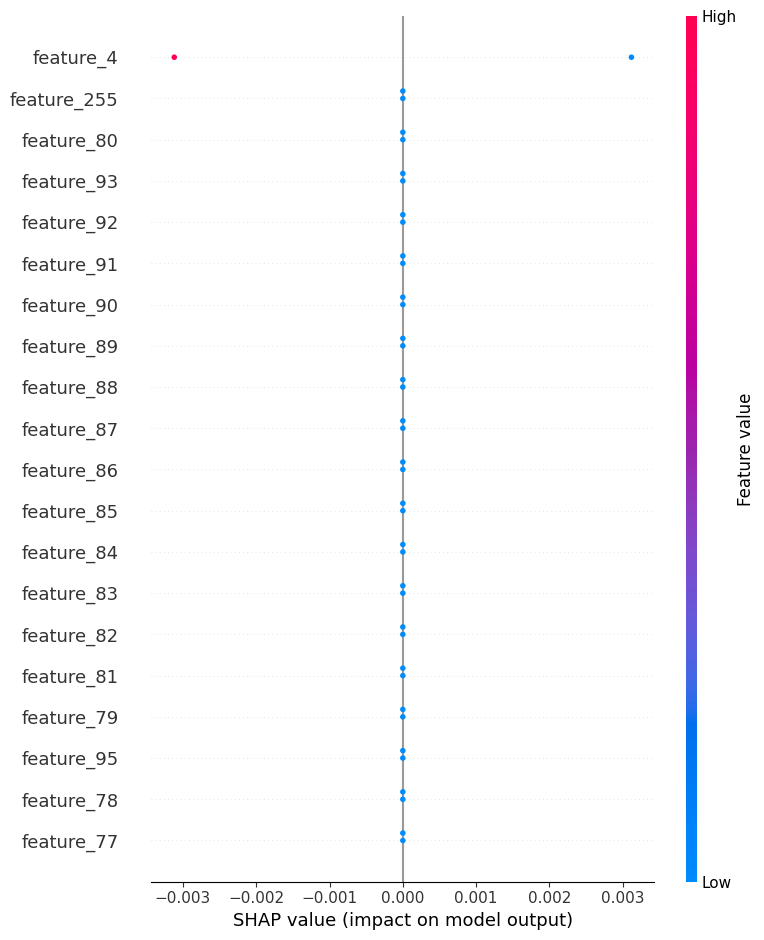

In [15]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import shap
import numpy as np

# Define a dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer and define BiLSTM model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(BiLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embedded = bert_outputs.last_hidden_state
        
        _, (hidden, _) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output

# Initialize the model
input_dim = 768  # BERT hidden size
hidden_dim = 256
output_dim = 2
n_layers = 2
bidirectional = True
dropout = 0.5

model = BiLSTM(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Training setup
def train_model(model, dataloader, optimizer, criterion, epochs=3):
    model = model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Sample training data
texts = ["This is a fake news article.", "This is a genuine news article."]
labels = [1, 0]
dataset = FakeNewsDataset(texts, labels, tokenizer, max_len=128)
dataloader = DataLoader(dataset, batch_size=2)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train the model
train_model(model, dataloader, optimizer, criterion)

# Extract inputs and convert to numpy arrays for SHAP
input_ids = []
attention_masks = []
for i in range(len(dataset)):
    sample = dataset[i]
    input_ids.append(sample['input_ids'].numpy())
    attention_masks.append(sample['attention_mask'].numpy())

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

# Define a prediction function for SHAP
def predict(inputs):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor(inputs[:, :128], dtype=torch.long)
        attention_mask = torch.tensor(inputs[:, 128:], dtype=torch.long)
        outputs = model(input_ids, attention_mask)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities[:, 1].numpy()  # Probability of being fake news

# Combine input_ids and attention_masks for SHAP
combined_inputs = np.hstack([input_ids, attention_masks])

# Initialize SHAP explainer
explainer = shap.Explainer(predict, combined_inputs)

# Compute SHAP values
shap_values = explainer(combined_inputs)

# Visualize SHAP values
shap.summary_plot(shap_values, feature_names=[f'feature_{i}' for i in range(combined_inputs.shape[1])])


In [16]:
pip install torch torchvision transformers shap tf-keras

Note: you may need to restart the kernel to use updated packages.


PermutationExplainer explainer: 3it [03:36, 108.41s/it]                                                                


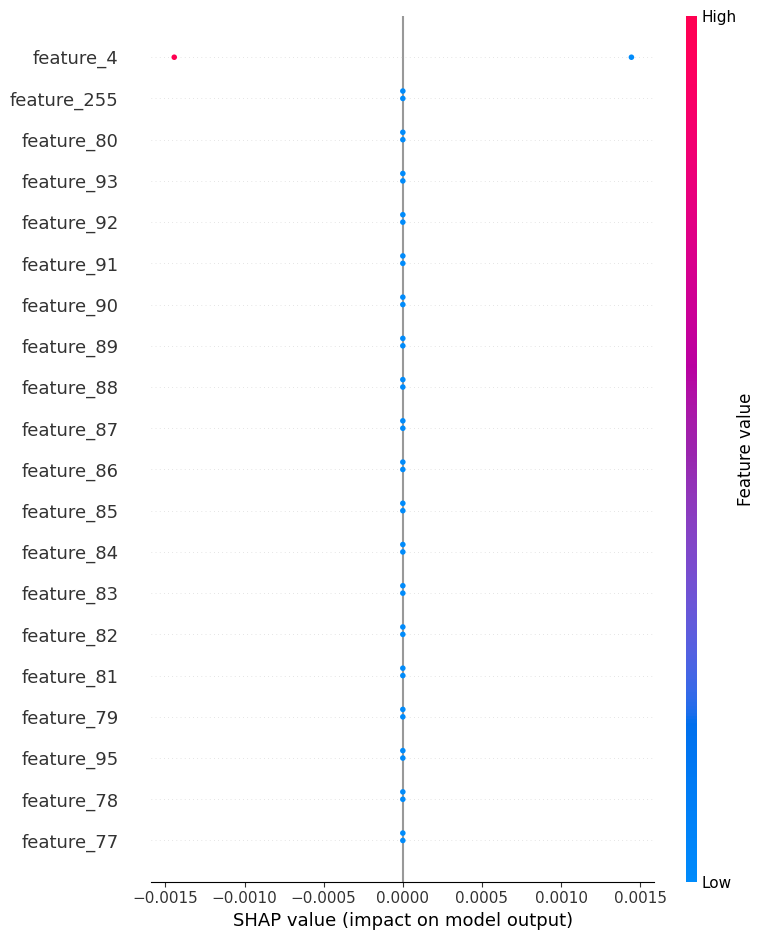

In [17]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import shap
import numpy as np

# Define a dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer and define BiLSTM model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(BiLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embedded = bert_outputs.last_hidden_state
        
        _, (hidden, _) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output

# Initialize the model
input_dim = 768  # BERT hidden size
hidden_dim = 256
output_dim = 2
n_layers = 2
bidirectional = True
dropout = 0.5

model = BiLSTM(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Training setup
def train_model(model, dataloader, optimizer, criterion, epochs=3):
    model = model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Sample training data
texts = ["This is a fake news article.", "This is a genuine news article."]
labels = [1, 0]
dataset = FakeNewsDataset(texts, labels, tokenizer, max_len=128)
dataloader = DataLoader(dataset, batch_size=2)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train the model
train_model(model, dataloader, optimizer, criterion)

# Extract inputs and convert to numpy arrays for SHAP
input_ids = []
attention_masks = []
for i in range(len(dataset)):
    sample = dataset[i]
    input_ids.append(sample['input_ids'].numpy())
    attention_masks.append(sample['attention_mask'].numpy())

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

# Define a prediction function for SHAP
def predict(inputs):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor(inputs[:, :128], dtype=torch.long)
        attention_mask = torch.tensor(inputs[:, 128:], dtype=torch.long)
        outputs = model(input_ids, attention_mask)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities[:, 1].numpy()  # Probability of being fake news

# Combine input_ids and attention_masks for SHAP
combined_inputs = np.hstack([input_ids, attention_masks])

# Initialize SHAP explainer
explainer = shap.Explainer(predict, combined_inputs)

# Compute SHAP values
shap_values = explainer(combined_inputs)

# Visualize SHAP values
shap.summary_plot(shap_values, feature_names=[f'feature_{i}' for i in range(combined_inputs.shape[1])])
